# Q. #1

In [9]:
# Import necessary packages
import itertools as it # Readable nested for loops
from pathlib import Path # Filepaths
import typing # Argument / output type checking
import numpy as np # N-dim arrays + math
import scipy.linalg as spla # Complex linear algebra
import matplotlib.pyplot as plt # Plots
import matplotlib.figure as figure # Figure documentation
import scipy.signal as spsg # Signal processing
import sympy # Symbolic math + pretty printing

# Logistics
sympy.init_printing()
figs_dir = (Path.cwd() / "figs")
figs_dir.mkdir(parents = True, exist_ok = True)
prob = 1

In [10]:
def etch(sym: str, mat: np.ndarray):
    display(sympy.Eq(sympy.Symbol(sym),
                     sympy.Matrix(mat.round(5)),
                     evaluate = False))
    pass


def d2c(A: np.ndarray, B: np.ndarray,
        dt: float) \
        -> typing.Tuple[np.ndarray, np.ndarray]:
    """Convert discrete linear state space model to continuous linear state space model.

    :param np.ndarray A:
    :param np.ndarray B:
    :param float dt: Timestep duration
    :return: (A_c, B_c) Continuous-time linear state space model
    """
    A_c = spla.logm(A)/dt
    if np.linalg.cond(A - np.eye(*A.shape)) < 1/np.spacing(1):
        B_c = A_c @ spla.inv(A - np.eye(*A.shape)) @ B
    else:
        B_temp = np.zeros(A_c.shape)
        for i in range(200):
            B_temp += (1/((i + 1)*np.math.factorial(i)))*np.linalg.matrix_power(A_c, i)*(dt**(i + 1))
        B_c = B @ spla.inv(B_temp)
    return A_c, B_c


def c2d(A_c: np.ndarray, B_c: np.ndarray,
        dt: float) \
        -> typing.Tuple[np.ndarray, np.ndarray]:
    """Convert continuous linear state space model to discrete linear state space model.

    :param np.ndarray A_c:
    :param np.ndarray B_c:
    :param float dt: Timestep duration
    :return: (A, B) Discrete-time linear state space model
    """
    A = spla.expm(A_c*dt)
    if np.linalg.cond(A_c) < 1/np.spacing(1):
        B = (A - np.eye(*A.shape)) @ spla.inv(A_c) @ B_c
    else:
        B_temp = np.zeros(A_c.shape)
        for i in range(200):
            B_temp += (1/((i + 1)*np.math.factorial(i)))*np.linalg.matrix_power(A_c, i)*(dt**(i + 1))
        B = B_temp @ B_c
    return A, B


def sim_ss(A: np.ndarray, B: np.ndarray, C: np.ndarray, D: np.ndarray,
           X_0: np.ndarray, U: np.ndarray,
           nt: int) \
        -> typing.Tuple[np.ndarray, np.ndarray]:
    """Simulate linear state space model via ZOH.

    :param np.ndarray A:
    :param np.ndarray B:
    :param np.ndarray C:
    :param np.ndarray D:
    :param np.ndarray X_0: Initial state condition
    :param np.ndarray U: Inputs, either impulse or continual
    :param nt: Number of timesteps to simulate
    :return: (X) State vector array over duration; (Z) Observation vector array over duration
    """
    assert D.shape == (C @ A @ B).shape
    assert X_0.shape[-2] == A.shape[-1]
    assert U.shape[-2] == B.shape[-1]
    assert A.shape[-2] == B.shape[-2]
    assert C.shape[-2] == D.shape[-2]
    assert A.shape[-1] == C.shape[-1]
    assert B.shape[-1] == D.shape[-1]
    assert (U.shape[-1] == 1) or (U.shape[-1] == nt) or (U.shape[-1] == nt - 1)

    X = np.concatenate([X_0, np.zeros([X_0.shape[-2], nt])], 1)
    Z = np.zeros([C.shape[-2], nt])
    if U.shape[-1] == 1: # Impulse
        X[:, 1] = (A @ X[:, 0]) + (B @ U[:, 0])
        Z[:, 0] = (C @ X[:, 0]) + (D @ U[:, 0])
        for i in range(1, nt):
            X[:, i + 1] = (A @ X[:, i])
            Z[:, i] = (C @ X[:, i])
    else: # Continual
        for i in range(nt):
            X[:, i + 1] = (A @ X[:, i]) + (B @ U[:, i])
            Z[:, i] = (C @ X[:, i]) + (D @ U[:, i])
    return X, Z


def markov_sim(Y: np.ndarray, U: np.ndarray) \
        -> np.ndarray:
    """Obtain observations from Markov parameters and inputs, for zero initial conditions

    :param np.ndarray Y: Markov parameter matrix
    :param np.ndarray U: Continual inputs
    :return: (Z) Observation vector array over duration
    :rtype: np.ndarray
    """
    l, m, r = Y.shape
    Y_2_Z = np.zeros([r*l, l])
    Y_2_Z[:r, :] = U
    for i in range(1, l):
        Y_2_Z[r*i:r*(i + 1), :] = np.concatenate([np.zeros([r, i]), U[:, 0:(-i)]], 1)
    Z = np.concatenate(Y, 1) @ Y_2_Z
    return Z


def ss2markov(A: np.ndarray, B: np.ndarray, C: np.ndarray, D: np.ndarray,
              nt: int) \
        -> np.ndarray:
    """Get Markov parameters from state space model.

    :param np.ndarray A:
    :param np.ndarray B:
    :param np.ndarray C:
    :param np.ndarray D:
    :param nt: Number of Markov parameters to generate (i.e., length of simulation)
    :return: (Y) 3D array of Markov parameters
    :rtype: np.ndarray
    """
    assert D.shape == (C @ A @ B).shape
    Y = np.zeros([nt, *D.shape])
    Y[0] = D
    for i in range(1, nt):
        Y[i] = C @ (np.linalg.matrix_power(A, i - 1)) @ B
    return Y


def Hankel(Y: np.ndarray, alpha: int, beta: int, i: int = 0) \
        -> np.ndarray:
    """Hankel matrix.

    :param Y: Markov parameter matrix
    :param alpha: Num. of rows of Markov parameters in Hankel matrix
    :param beta: Num. of columns of Markov parameters in Hankel matrix
    :param i: Start node of Hankel matrix
    :return: Block Hankel matrix.
    :rtype: np.ndarray
    """
    assert (len(Y) - 1) >= (i + alpha + beta - 1)
    m, r = Y.shape[-2:]
    H = np.zeros([alpha*m, beta*r])
    for j in range(beta):
        H[:, (j*r):((j + 1)*r)] = Y[(i + 1 + j):(i + alpha + 1 + j)].reshape([alpha*m, r])
    return H


def era(Y: np.ndarray, alpha: int, beta: int, n: int) \
        -> typing.Tuple[np.ndarray,
                        np.ndarray,
                        np.ndarray,
                        np.ndarray,
                        np.ndarray]:
    """Eigensystem Realization Algorithm (ERA).

    :param np.ndarray Y: Markov parameter matrix
    :param int alpha: Num. of rows of Markov parameters in Hankel matrix
    :param int beta: Num. of columns of Markov parameters in Hankel matrix
    :param int n: Order of proposed linear state space system
    :returns: (A, B, C, D) - State space of proposed linear state space system; (S) - Singular Values of H(0)
    :rtype: (np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray)
    """
    assert (len(Y) - 1) >= (alpha + beta - 1)
    m, r = Y.shape[-2:]
    assert (alpha >= (n/m)) and (beta >= (n/r))
    H_0 = Hankel(Y, alpha, beta, 0)
    print(f"Rank of H(0): {np.linalg.matrix_rank(H_0)}")
    H_1 = Hankel(Y, alpha, beta, 1)
    print(f"Rank of H(1): {np.linalg.matrix_rank(H_1)}")
    U_sim, S, Vh = np.linalg.svd(H_0)
    V = Vh.T
    U_n = U_sim[:, :n]
    V_n = V[:, :n]
    S_n = S[:n]

    E_r = np.concatenate([np.eye(r), np.tile(np.zeros([r, r]), beta - 1)], 1).T
    E_m = np.concatenate([np.eye(m), np.tile(np.zeros([m, m]), alpha - 1)], 1).T
    A = np.diag(S_n**(-1/2)) @ U_n.T @ H_1 @ V_n @ np.diag(S_n**(-1/2))
    B = np.diag(S_n**(1/2)) @ V_n.T @ E_r
    C = E_m.T @ U_n @ np.diag(S_n**(1/2))
    D = Y[0]
    return A, B, C, D, S


def okid(Z: np.ndarray, U: np.ndarray,
         l_0: int,
         alpha: int, beta: int,
         n: int):
    """Observer Kalman Identification Algorithm (OKID).

    :param np.ndarray Z: Observation vector array over duration
    :param np.ndarray U: Continual inputs
    :param int l_0: Order of OKID to execute (i.e., number of Markov parameters to generate via OKID)
    :param int alpha: Num. of rows of Markov parameters in Hankel matrix
    :param int beta: Num. of columns of Markov parameters in Hankel matrix
    :param int n: Number of proposed states to use for ERA
    :return: (Y) Markov parameters
    :rtype: np.ndarray
    """
    r, l_u = U.shape
    m, l  = Z.shape
    assert l == l_u
    V = np.concatenate([U, Z], 0)
    assert (max([alpha + beta, (n/m) + (n/r)]) <= l_0) and (l_0 <= (l - r)/(r + m)) # Boundary conditions

    # Form observer
    Y_2_Z = np.zeros([r + (r + m)*l_0, l])
    Y_2_Z[:r, :] = U
    for i in range(1, l_0 + 1):
        Y_2_Z[((i*r) + ((i - 1)*m)):(((i + 1)*r) + (i*m)), :] = np.concatenate([np.zeros([r + m, i]), V[:, 0:(-i)]], 1)
    # Find Observer Markov parameters via least-squares
    Y_obs = Z @ spla.pinv2(Y_2_Z)
    Y_bar_1 = np.array(list(it.chain.from_iterable([Y_obs[:, i:(i + r)]
                                                    for i in range(r, r + (r + m)*l_0, r + m)]))).reshape([l_0, m, r])
    Y_bar_2 = -np.array(list(it.chain.from_iterable([Y_obs[:, i:(i + m)]
                                                     for i in range(2*r, r + (r + m)*l_0, r + m)]))).reshape([l_0, m, m])

    # Obtain Markov parameters from Observer Markov parameters
    Y = np.zeros([l_0 + 1, m, r])
    Y[0] = Y_obs[:, :r]
    for k in range(1, l_0 + 1):
        Y[k] = Y_bar_1[k - 1] - \
               np.array([Y_bar_2[i] @ Y[k - (i + 1)]
                         for i in range(k)]).sum(axis = 0)
    # Obtain Observer Gain Markov parameters from Observer Markov parameters
    Y_og = np.zeros([l_0, m, m])
    Y_og[0] = Y_bar_2[0]
    for k in range(1, l_0):
        Y_og[k] = Y_bar_2[k] - \
                  np.array([Y_bar_2[i] @ Y_og[k - (i + 1)]
                            for i in range(k - 1)]).sum(axis = 0)
    return Y, Y_og

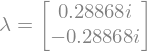

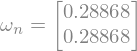

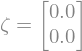

In [11]:
# Set seed for consistent results
rng = np.random.default_rng(seed = 100)

# Simulation dimensions
cases = 3 # Number of cases
n = 2 # Number of states
r = 1 # Number of inputs
m = 2 # Number of measurements
t_max = 50 # Total simulation time
dt = 0.1 # Simulation timestep duration
nt = int(t_max/dt) # Number of simulation timesteps

# Simulation time
train_cutoff = int(20/dt) + 1
t_sim = np.linspace(0, t_max, nt + 1)
t_train = t_sim[:train_cutoff]
t_test = t_sim
nt_train = train_cutoff
nt_test = nt

# Problem parameters
theta_0 = 0.5 # Angular velocity
k = 1 # Spring stiffness
mass = 3 # Point mass

# State space model
A_c = np.array([[0, 1], [theta_0**2 - k/mass, 0]])
B_c = np.array([[0], [1]])
C = np.eye(2)
D = np.array([[0], [1]])
A, B = c2d(A_c, B_c, dt)
eig_A = spla.eig(A_c)[0] # Eigenvalues of true system
etch(f"\lambda", eig_A)
etch(f"\omega_{{n}}", np.abs(eig_A))
etch(f"\zeta", -np.cos(np.angle(eig_A)))

# True simulation values
X_0_sim = np.zeros([n, 1]) # Zero initial condition
U_sim = np.zeros([cases, r, nt]) # True input vectors
U_sim[0] = rng.normal(0, 0.1, [r, nt]) # True input for case 1
U_sim[1] = spsg.square(2*np.pi*5*t_sim[:-1]) # True input for case 2
U_sim[2] = np.cos(2*np.pi*2*t_sim[:-1]) # True input for case 3
X_sim = np.zeros([cases, n, nt + 1]) # True state vectors
Z_sim = np.zeros([cases, m, nt]) # True observation vectors

# Separation into train and test data
U_train = U_sim[0, :r, :train_cutoff] # Train input vector
U_test = U_sim # Test input vectors
X_train = np.zeros([n, nt_train + 1]) # Train state vector
X_test = np.zeros([cases, n, nt_test + 1]) # Test state vectors
Z_train = np.zeros([m, nt_train]) # Train observation vector
Z_test = np.zeros([cases, m, nt_test]) # Test observation vectors

In [12]:
# OKID logistics
order = 50 # Order of OKID algorithm, number of Markov parameters to identify after the zeroeth
alpha, beta = 15, 20 # Number of block rows and columns in Hankel matrices
n_era = 2 # Number of proposed states
X_0_okid = np.zeros([n_era, 1]) # Zero initial condition

print(f"Min. OKID Order: {max([alpha + beta, (n_era/m) + (n_era/r)]):n}")
print(f"Max. OKID Order: {(nt_train - r)/(r + m):n}")
print(f"Proposed OKID Order: {order:n}")

Min. OKID Order: 35
Max. OKID Order: 66.6667
Proposed OKID Order: 50


We propose to use an OKID order $l_0$ of $50$,
since this value falls inside the range of permitted OKID orders.

The Hankel matrix $H(0)$ must be at least rank $n$.
In addition, the sum of the numbers of block rows ($\alpha$) and columns ($\beta$)
should be at most the number of estimated Markov parameters (i.e., the OKID order $l_0 = 50$).
Moreover, to meet the full rank condition for $H(0)$, $\alpha \ge \frac{n}{m} = 1$ and $\beta \ge \frac{n}{r} = 2$.
To meet these criteria, we choose $\alpha = 15$ and $\beta = 20$.

As shown by the SVD plot below, the order of the system appears to be $2$,
since there is a sharp dropoff in the value of the singular values for $n > 2$.
Therefore, we will choose the number of states for the OKID/ERA-proposed system to be $2$.

In [13]:
# OKID System Markov parameters
Y_okid = np.zeros([order + 1, m, r])
# OKID Observer Markov Gain parameters
Y_og_okid = np.zeros([order, m, m])
# OKID state vector, drawn from state space model derived from OKID/ERA
X_okid_train = np.zeros([n_era, nt_train + 1])
X_okid_test = np.zeros([cases, n_era, nt_test + 1])
# OKID observations, drawn from state space model derived from OKID/ERA
Z_okid_train = np.zeros([n_era, nt_train])
Z_okid_test = np.zeros([cases, n_era, nt_test])
# Singular values of the Hankel matrix constructed through OKID Markov parameters
S_okid = np.zeros([min(alpha*m, beta*r)])
eig_A_okid = np.zeros([n_era], dtype = complex)

Rank of H(0): 2
Rank of H(1): 2


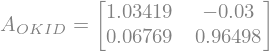

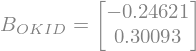

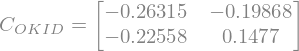

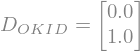

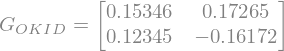

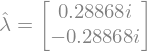

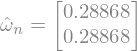

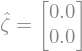

In [14]:
# Simulation
for i in range(cases):
    X_sim[i], Z_sim[i] = sim_ss(A, B, C, D, X_0 = X_0_sim, U = U_sim[i], nt = nt)
    if i == 0:
        # Split between train and test data for case 1
        X_train, Z_train = X_sim[i, :, :train_cutoff], Z_sim[i, :, :train_cutoff]
        # Identify System Markov parameters and Observer Gain Markov parameters
        Y_okid, Y_og_okid = okid(Z_train, U_train,
                                 l_0 = order, alpha = alpha, beta = beta, n = n_era)
        # Identify state space model using System Markov parameters for ERA
        A_okid, B_okid, C_okid, D_okid, S_okid = \
            era(Y_okid, alpha = alpha, beta = beta, n = n_era)
        # Construct observability matrix
        O_p_okid = np.array([C_okid @ np.linalg.matrix_power(A_okid, i)
                             for i in range(order)])
        # Find observer gain matrix
        G_okid = spla.pinv2(O_p_okid.reshape([order*m, n_era])) @ Y_og_okid.reshape([order*m, m])
        X_okid_train, Z_okid_train = sim_ss(A_okid, B_okid, C_okid, D_okid,
                                            X_0 = X_0_okid, U = U_train, nt = nt_train)
        # Display outputs
        etch(f"A_{{OKID}}", A_okid)
        etch(f"B_{{OKID}}", B_okid)
        etch(f"C_{{OKID}}", C_okid)
        etch(f"D_{{OKID}}", D_okid)
        etch(f"G_{{OKID}}", G_okid)
        # Calculate and display eigenvalues
        eig_A_okid = spla.eig(d2c(A_okid, B_okid, dt)[0])[0] # Eigenvalues of identified system
        etch(f"\hat{{\lambda}}", eig_A_okid)
        etch(f"\hat{{\omega}}_{{n}}", np.abs(eig_A_okid))
        etch(f"\hat{{\zeta}}", -np.cos(np.angle(eig_A_okid)))
    X_test[i], Z_test[i] = X_sim[i], Z_sim[i]
    X_okid_test[i], Z_okid_test[i] = sim_ss(A_okid, B_okid, C_okid, D_okid,
                                            X_0 = X_0_okid, U = U_test[i], nt = nt_test)

The eigenvalues of the system are accurately identified via OKID.
The natural frequencies and damping ratios are essentially exactly identified.

In [15]:
RMS_train = np.sqrt(np.mean((Z_okid_train - Z_train)**2, axis = 1))
print(f"RMS Error of sim. for system found via OKID for train data: {RMS_train}")
RMS_test = np.zeros([cases, m])
for i in range(cases):
    RMS_test[i] = np.sqrt(np.mean((Z_okid_test[i] - Z_test[i])**2, axis = 1))
    print(f"RMS Error of sim. for system found via OKID for test data, case {i}: {RMS_test[i]}")

RMS Error of sim. for system found via OKID for train data: [7.91793053e-15 2.08865251e-15]
RMS Error of sim. for system found via OKID for test data, case 0: [5.50948541e-14 1.19985519e-14]
RMS Error of sim. for system found via OKID for test data, case 1: [1.00135613e-12 2.02885055e-13]
RMS Error of sim. for system found via OKID for test data, case 2: [2.98872465e-14 8.45833578e-15]


In [16]:
# Eigenvalue plots
fig, ax = plt.subplots(constrained_layout = True) # type:figure.Figure
fig.suptitle(f"[{prob}] Eigenvalues", fontweight = "bold")

ax.plot(np.real(eig_A), np.imag(eig_A),
         "o", mfc = "None")
ax.plot(np.real(eig_A_okid), np.imag(eig_A_okid),
         "s", mfc = "None")

fig.legend(labels = ("True", "OKID"),
           bbox_to_anchor = (1, 0.5), loc = 6)
fig.savefig(figs_dir / f"midterm_{prob}_eigval.pdf",
            dpi = 80, bbox_inches = "tight")

# Singular Value plots
fig, ax = plt.subplots(constrained_layout = True) # type:figure.Figure
fig.suptitle(f"[{prob}] Singular Values", fontweight = "bold")

ax.plot(np.linspace(1, len(S_okid), len(S_okid)), S_okid,
         "o", mfc = "None")
plt.setp(ax, xlabel = f"Singular Value", ylabel = f"Value",
         xticks = np.arange(1, len(S_okid) + 1))

fig.savefig(figs_dir / f"midterm_{prob}_singval.pdf",
            dpi = 80, bbox_inches = "tight")

# Response plots
ms = 0.5 # Marker size
for i in range(cases):
    fig, axs = plt.subplots(1 + n, 1,
                            sharex = "col",
                            constrained_layout = True) # type:figure.Figure
    fig.suptitle(f"[{prob}] State Responses (Case {i + 1})",
                 fontweight = "bold")

    if i == 0:
        axs[i].plot(t_sim[:-1], U_sim[i, 0])
        axs[i].plot(t_train, U_train[0],
                    "o", ms = ms, mfc = "None")
        axs[i].plot(t_test[train_cutoff:-1], U_test[i, 0, train_cutoff:],
                    "s", ms = ms, mfc = "None")
        plt.setp(axs[i], ylabel = f"$u$", xlim = [0, t_max])

        for j in range(n):
            axs[j + 1].plot(t_sim, X_sim[i, j])
            axs[j + 1].plot(t_train, X_train[j],
                            "o", ms = ms, mfc = "None")
            axs[j + 1].plot(t_test[train_cutoff:], X_test[i, j, train_cutoff:],
                            "s", ms = ms, mfc = "None")
            plt.setp(axs[j + 1], ylabel = f"$x_{j}$", xlim = [0, t_max])
            if j == 1:
                plt.setp(axs[j + 1], xlabel = f"Time")
        fig.legend(labels = ("True", "Train", "Test"),
                   bbox_to_anchor = (1, 0.5), loc = 6)
    else:
        axs[0].plot(t_sim[:-1], U_sim[i, 0])
        axs[0].plot(t_test[:-1], U_test[i, 0],
                    "o", ms = ms, mfc = "None")
        plt.setp(axs[0], ylabel = f"$u$", xlim = [0, t_max])

        for j in range(n):
            axs[j + 1].plot(t_sim, X_sim[i, j])
            axs[j + 1].plot(t_test, X_test[i, j],
                            "o", ms = ms, mfc = "None")
            plt.setp(axs[j + 1], ylabel = f"$x_{j}$", xlim = [0, t_max])
            if j == 1:
                plt.setp(axs[j + 1], xlabel = f"Time")
        fig.legend(labels = ("True", "Test"),
                   bbox_to_anchor = (1, 0.5), loc = 6)
    fig.savefig(figs_dir / f"midterm_{prob}_states_case{i + 1}.pdf",
                dpi = 80, bbox_inches = "tight")

# Observation plots
for i in range(cases):
    fig, axs = plt.subplots(m, 1,
                            sharex = "col",
                            constrained_layout = True) # type:figure.Figure
    fig.suptitle(f"[{prob}] Observation Responses (Case {i + 1})",
                 fontweight = "bold")
    if i == 0:
        for j in range(m):
            axs[j].plot(t_sim[:-1], Z_sim[i, j])
            axs[j].plot(t_train, Z_train[j],
                        "o", ms = ms, mfc = "None")
            axs[j].plot(t_test[train_cutoff:-1], Z_test[i, j, train_cutoff:],
                        "s", ms = ms, mfc = "None")
            axs[j].plot(t_train, Z_okid_train[j],
                        "o", ms = ms, mfc = "None")
            axs[j].plot(t_test[train_cutoff:-1], Z_okid_test[i, j, train_cutoff:],
                        "D", ms = ms, mfc = "None")
            plt.setp(axs[j], ylabel = f"$z_{j}$",
                     xlim = [0, t_max])
            if j == (m - 1):
                plt.setp(axs[j], xlabel = f"Time")
        fig.legend(labels = ["True", "Train", "Test",
                             "OKID\n(Train)", "OKID\n(Test)"],
                   bbox_to_anchor = (1, 0.5), loc = 6)
    else:
        for j in range(m):
            axs[j].plot(t_sim[:-1], Z_sim[i, j])
            axs[j].plot(t_test[:-1], Z_test[i, j],
                        "o", ms = ms, mfc = "None")
            axs[j].plot(t_test[:-1], Z_okid_test[i, j],
                        "s", ms = ms, mfc = "None")
            plt.setp(axs[j], ylabel = f"$z_{j}$",
                     xlim = [0, t_max])
            if j == (m - 1):
                plt.setp(axs[j], xlabel = f"Time")
        fig.legend(labels = ["True", "Test", "OKID\nTest"],
                   bbox_to_anchor = (1, 0.5), loc = 6)
    fig.savefig(figs_dir / f"midterm_{prob}_obs_case{i + 1}.pdf",
                dpi = 80, bbox_inches = "tight")

    fig, axs = plt.subplots(m, 1,
                            sharex = "col",
                            constrained_layout = True) # type:figure.Figure
    fig.suptitle(f"[{prob}] Observation Error (Case {i + 1})",
                 fontweight = "bold")
    if i == 0:
        for j in range(m):
            axs[j].plot(t_train, np.abs(Z_okid_train[j] - Z_train[j]),
                        c = "C1")
            axs[j].plot(t_test[train_cutoff:-1], np.abs(Z_okid_test[i, j, train_cutoff:] - Z_test[i, j, train_cutoff:]),
                        "o", ms = ms, mfc = "None", c = "C0")
            plt.setp(axs[j], ylabel = f"$z_{j}$",
                     xlim = [0, t_max])
            if j == (m - 1):
                plt.setp(axs[j], xlabel = f"Time")
        fig.legend(labels = ["OKID\nTrain", "OKID\nTest"],
                   bbox_to_anchor = (1, 0.5), loc = 6)
    else:
        for j in range(m):
            axs[j].plot(t_test[:-1], np.abs(Z_okid_test[i, j] - Z_test[i, j]),
                        "o", ms = ms, mfc = "None")
            plt.setp(axs[j], ylabel = f"$z_{j}$",
                     xlim = [0, t_max])
            if j == (m - 1):
                plt.setp(axs[j], xlabel = f"Time")
        fig.legend(labels = ["OKID\nTest"],
                   bbox_to_anchor = (1, 0.5), loc = 6)
    fig.savefig(figs_dir / f"midterm_{prob}_obs-error_case{i + 1}.pdf",
                dpi = 80, bbox_inches = "tight")

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 3 Axes>

<Figure size 640x480 with 3 Axes>

<Figure size 640x480 with 3 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>